In [2]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from functools import partial
import unicodedata 
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import IsolationForest

In [3]:
df = pd.read_csv(r"D:\tesis_u_sabana\data\secop_2_contratos_1.csv", sep="~")
df = df.dropna(subset=['fecha_de_firma'])
df.head(5)

C:\Users\pipe\AppData\Local\Temp\ipykernel_13288\1461258309.py:1: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"D:\tesis_u_sabana\data\secop_2_contratos_1.csv", sep="~")


nombre_entidad  nit_entidad  \
0                 DANE - DIRECCION TERRITORIAL NORTE    899999027   
2  SENA REGIONAL ANTIOQUIA Grupo Administrativo C...    899999034   
3                          ALCALDIA LOCAL DE USAQUEN    899999061   
4                              DEPARTAMENTO DEL META   8920001488   
5                       MUNICIPIO MANTA CUNDINAMARCA    800094711   

                 departamento         ciudad  \
0                   Atlantico    No Definido   
2                   Antioquia         Itagui   
3  Distrito Capital de Bogota         Bogota   
4                        Meta  Villavicencio   
5                Cundinamarca          Manta   

                         localizacion        orden                   sector  \
0  Colombia;  Atlantico ; No Definido     Nacional  Informacion Estadistica   
2      Colombia;  Antioquia ;  Itagui     Nacional                  Trabajo   
3           Colombia; Bogota;  Bogota  Territorial         Servicio Publico   
4    Colombia;  Meta ;  Villavicencio  Territorial         Servicio Publico   
5    Colombia;  Cundinamarca ;  Manta  Territorial         Servicio Publico   

        rama entidad_centralizada proceso_de_compra  ...  \
0  Ejecutivo      Descentralizada  CO1.BDOS.6741237  ...   
2  Ejecutivo      Descentralizada  CO1.BDOS.1099719  ...   
3  Ejecutivo      Descentralizada  CO1.BDOS.4578022  ...   
4  Ejecutivo      Descentralizada  CO1.BDOS.3550103  ...   
5  Ejecutivo      Descentralizada  CO1.BDOS.7117742  ...   

  fecha_de_notificacion_de_prorrogacion       nombre_ordenador_del_gasto  \
0                                   NaN  CADID ASDRUBAL SAAVEDRA CASTANO   
2                  12092020 12:00:00 AM         ELKIN DARIO TOBoN TAMAYO   
3                                   NaN                      No definido   
4                                   NaN    MARIA DAYINETH DUARTE SANCHEZ   
5                                   NaN                      No definido   

  tipo_de_documento_ordenador_del_gasto  \
0                  Cedula de Ciudadania   
2                  Cedula de Ciudadania   
3                           No definido   
4                  Cedula de Ciudadania   
5                           No definido   

  numero_de_documento_ordenador_del_gasto           nombre_supervisor  \
0                                79540901   OSCAR DE JESUS DAZA LEMUS   
2                                98571178  MARiA NELA HENAO ATEHORTUA   
3                             No definido                 No definido   
4                                40040538  DIEGO MAURICIO GALVIS WOLF   
5                             No definido                 No definido   

  tipo_de_documento_supervisor numero_de_documento_supervisor  \
0         Cedula de Ciudadania                       77020546   
2         Cedula de Ciudadania                       43750094   
3                  No definido                    No definido   
4         Cedula de Ciudadania                       86088385   
5                  No definido                    No definido   

  nombre_ordenador_de_pago  tipo_de_documento_ordenador_de_pago  \
0              No definido                          No definido   
2              No definido                          No definido   
3              No definido                          No definido   
4              No definido                          No definido   
5              No definido                          No definido   

   numero_de_documento_ordenador_de_pago  
0                            No definido  
2                            No definido  
3                            No definido  
4                            No definido  
5                            No definido  

[5 rows x 87 columns]

In [4]:
target_data = df[["valor_del_contrato"]]  

iso_forest_column = IsolationForest(n_estimators=100, contamination=0.001, random_state=23)
outliers_column = iso_forest_column.fit_predict(target_data)

df = df[outliers_column == 1]

In [5]:
# Definir las funciones
def eliminar_tildes(texto):
    if not isinstance(texto, str):  # Manejo de valores no str
        return texto
    texto_normalizado = unicodedata.normalize('NFKD', texto)
    texto_sin_tildes = ''.join([c for c in texto_normalizado if not unicodedata.combining(c)])
    return texto_sin_tildes

def lower_1(bagtoprocess):
    if not isinstance(bagtoprocess, str):  # Manejo de valores no str
        return bagtoprocess
    return bagtoprocess.lower()

def limpiar_inicial_dataframe(df):
    return df.map(lambda x: lower_1(eliminar_tildes(x)) if isinstance(x, str) else x)

df = limpiar_inicial_dataframe(df)

In [6]:
def parse_mmddyyyy(value):
    """
    Converts MMDDYYYY format into a proper date format.
    - Handles both numeric and string-based dates.
    - Removes time component if present.
    - Preserves missing values.
    """
    if pd.isna(value):  
        return None  # Handle missing values
    
    if isinstance(value, pd.Timestamp):  
        return value  # Already a datetime, no need to convert

    try:
        # If the value is a string with time (e.g., "09162021 12:00:00 AM")
        if isinstance(value, str):
            value_str = re.findall(r"\d{8}", value)  # Extract only 8-digit date
            if value_str:
                value_str = value_str[0]  # Use the first match
            else:
                return None  # Return None if no valid date is found

        # If the value is numeric (e.g., 9162021.0)
        elif isinstance(value, (int, float)):
            value_str = str(int(value)).zfill(8)  # Convert to string and ensure 8-digit format

        else:
            return None  # Unrecognized format

        # Convert to datetime format
        return pd.to_datetime(value_str, format="%m%d%Y", errors="coerce")
    
    except (ValueError, TypeError):
        return None  # Handle errors gracefully
    

# Apply the function to all relevant columns
date_columns = [
    "fecha_de_firma",
    "fecha_de_inicio_del_contrato",
    "fecha_de_fin_del_contrato",
    "fecha_de_inicio_de_ejecucion",
    "fecha_de_fin_de_ejecucion",
    "fecha_de_notificacion_de_prorrogacion",
    "fecha_fin_liquidacion",
    "fecha_inicio_liquidacion",
    "ultima_actualizacion"
]

for col in date_columns:
    df[col] = df[col].apply(parse_mmddyyyy)


In [7]:
def convertir_a_dias(valor):
    if isinstance(valor, str):
        # Buscar número en la cadena
        match = re.search(r'(\d+)', valor)
        if match:
            numero = int(match.group(1))
            # Convertir meses a días
            if "mes" in valor:
                return numero * 30  # Asumiendo 1 mes = 30 días
            return numero  # Si ya está en días, devolverlo como está
    return None  # Para valores no válidos

# Aplicar la función a la columna
df["duracion_en_dias"] = df["duracion_del_contrato"].apply(convertir_a_dias)

In [8]:
df.head()

nombre_entidad  nit_entidad  \
0                 dane - direccion territorial norte    899999027   
2  sena regional antioquia grupo administrativo c...    899999034   
3                          alcaldia local de usaquen    899999061   
4                              departamento del meta   8920001488   
5                       municipio manta cundinamarca    800094711   

                 departamento         ciudad  \
0                   atlantico    no definido   
2                   antioquia         itagui   
3  distrito capital de bogota         bogota   
4                        meta  villavicencio   
5                cundinamarca          manta   

                         localizacion        orden                   sector  \
0  colombia;  atlantico ; no definido     nacional  informacion estadistica   
2      colombia;  antioquia ;  itagui     nacional                  trabajo   
3           colombia; bogota;  bogota  territorial         servicio publico   
4    colombia;  meta ;  villavicencio  territorial         servicio publico   
5    colombia;  cundinamarca ;  manta  territorial         servicio publico   

        rama entidad_centralizada proceso_de_compra  ...  \
0  ejecutivo      descentralizada  co1.bdos.6741237  ...   
2  ejecutivo      descentralizada  co1.bdos.1099719  ...   
3  ejecutivo      descentralizada  co1.bdos.4578022  ...   
4  ejecutivo      descentralizada  co1.bdos.3550103  ...   
5  ejecutivo      descentralizada  co1.bdos.7117742  ...   

        nombre_ordenador_del_gasto tipo_de_documento_ordenador_del_gasto  \
0  cadid asdrubal saavedra castano                  cedula de ciudadania   
2         elkin dario tobon tamayo                  cedula de ciudadania   
3                      no definido                           no definido   
4    maria dayineth duarte sanchez                  cedula de ciudadania   
5                      no definido                           no definido   

  numero_de_documento_ordenador_del_gasto           nombre_supervisor  \
0                                79540901   oscar de jesus daza lemus   
2                                98571178  maria nela henao atehortua   
3                             no definido                 no definido   
4                                40040538  diego mauricio galvis wolf   
5                             no definido                 no definido   

  tipo_de_documento_supervisor numero_de_documento_supervisor  \
0         cedula de ciudadania                       77020546   
2         cedula de ciudadania                       43750094   
3                  no definido                    no definido   
4         cedula de ciudadania                       86088385   
5                  no definido                    no definido   

  nombre_ordenador_de_pago tipo_de_documento_ordenador_de_pago  \
0              no definido                         no definido   
2              no definido                         no definido   
3              no definido                         no definido   
4              no definido                         no definido   
5              no definido                         no definido   

  numero_de_documento_ordenador_de_pago duracion_en_dias  
0                           no definido             82.0  
2                           no definido              NaN  
3                           no definido            180.0  
4                           no definido             30.0  
5                           no definido             24.0  

[5 rows x 88 columns]

In [9]:
tokenizer = RegexpTokenizer(r'\w+')

In [10]:
spanish_stopwords = set(stopwords.words('spanish'))
english_stopwords = set(stopwords.words('english'))
other_stopwords = set(["he" , "mas", "si","ser","aunque","hace","tan","solo",
                       "tambien","vez","parece","va","da","hacer","asi","haber",
                       "pues","ver","etc","contrato","servicios","prestacion",
                       "mediante","cuenta","fecha","presente","acuerdo","necesario","contratista",
                        "mil","servicio","requiere","contratos", "supervisor","cumplimiento","modificar",
                        "dar","realizar","objeto","contractual","pesos","modificacion",
                        "conforme","contratacion","gestion","entidad","apoyo","ejecucion",
                        "vigente","normatividad","acta","prestar","desarrollo","profesionales",
                        "actividades","desarrollo","procesos","marco","legal","prestacion", "especificaciones",
                        ])
stopword_set = spanish_stopwords.union(english_stopwords,other_stopwords)

In [11]:
def extract_reviews(bagtoprocess):
    if not isinstance(bagtoprocess, str):  # Manejo de valores no str
        return ""
    return bagtoprocess.lower()

def checkif_stopword(word, stopwords):
    return word not in stopwords

def filter_stopwords(tokens, stopwords):
    return list(filter(partial(checkif_stopword, stopwords=stopwords), tokens))

def eliminar_tildes(texto):
    if not isinstance(texto, str):  # Manejo de valores no str
        return ""
    texto_normalizado = unicodedata.normalize('NFKD', texto)
    texto_sin_tildes = ''.join([c for c in texto_normalizado if not unicodedata.combining(c)])
    return texto_sin_tildes

def eliminar_numeros(texto):
    if not isinstance(texto, str):  # Manejo de valores no str
        return ""
    return ''.join([c for c in texto if not c.isdigit()])

In [12]:
df['objeto_del_contrato'] = df['objeto_del_contrato'].astype(str)  # Asegurar que todo es string
df['objeto_del_contrato_sin_numeros'] = df['objeto_del_contrato'].apply(eliminar_numeros)
df['objeto_del_contrato_tokens'] = df['objeto_del_contrato_sin_numeros'].apply(tokenizer.tokenize)
df['objeto_del_contrato_limpio'] = df['objeto_del_contrato_tokens'].apply(partial(filter_stopwords, stopwords=stopword_set))

df['descripcion_del_proceso'] = df['descripcion_del_proceso'].astype(str)  # Asegurar que todo es string
df['descripcion_del_proceso_sin_numeros'] = df['descripcion_del_proceso'].apply(eliminar_numeros)
df['descripcion_del_proceso_tokens'] = df['descripcion_del_proceso_sin_numeros'].apply(tokenizer.tokenize)
df['descripcion_del_proceso_limpio'] = df['descripcion_del_proceso_tokens'].apply(partial(filter_stopwords, stopwords=stopword_set))
df.head()

nombre_entidad  nit_entidad  \
0                 dane - direccion territorial norte    899999027   
2  sena regional antioquia grupo administrativo c...    899999034   
3                          alcaldia local de usaquen    899999061   
4                              departamento del meta   8920001488   
5                       municipio manta cundinamarca    800094711   

                 departamento         ciudad  \
0                   atlantico    no definido   
2                   antioquia         itagui   
3  distrito capital de bogota         bogota   
4                        meta  villavicencio   
5                cundinamarca          manta   

                         localizacion        orden                   sector  \
0  colombia;  atlantico ; no definido     nacional  informacion estadistica   
2      colombia;  antioquia ;  itagui     nacional                  trabajo   
3           colombia; bogota;  bogota  territorial         servicio publico   
4    colombia;  meta ;  villavicencio  territorial         servicio publico   
5    colombia;  cundinamarca ;  manta  territorial         servicio publico   

        rama entidad_centralizada proceso_de_compra  ...  \
0  ejecutivo      descentralizada  co1.bdos.6741237  ...   
2  ejecutivo      descentralizada  co1.bdos.1099719  ...   
3  ejecutivo      descentralizada  co1.bdos.4578022  ...   
4  ejecutivo      descentralizada  co1.bdos.3550103  ...   
5  ejecutivo      descentralizada  co1.bdos.7117742  ...   

  nombre_ordenador_de_pago tipo_de_documento_ordenador_de_pago  \
0              no definido                         no definido   
2              no definido                         no definido   
3              no definido                         no definido   
4              no definido                         no definido   
5              no definido                         no definido   

  numero_de_documento_ordenador_de_pago duracion_en_dias  \
0                           no definido             82.0   
2                           no definido              NaN   
3                           no definido            180.0   
4                           no definido             30.0   
5                           no definido             24.0   

                     objeto_del_contrato_sin_numeros  \
0  ce__dra_bdc_th_tu prestacion de servicios de a...   
2  prestacion de los servicios personales de cara...   
3  prestar servicios profesionales para realizar ...   
4  fortalecer el departamento administrativo de p...   
5  prestacion de servicios de apoyo a la gestion ...   

                          objeto_del_contrato_tokens  \
0  [ce__dra_bdc_th_tu, prestacion, de, servicios,...   
2  [prestacion, de, los, servicios, personales, d...   
3  [prestar, servicios, profesionales, para, real...   
4  [fortalecer, el, departamento, administrativo,...   
5  [prestacion, de, servicios, de, apoyo, a, la, ...   

                          objeto_del_contrato_limpio  \
0  [ce__dra_bdc_th_tu, levantamiento, informacion...   
2  [personales, caracter, temporal, interprete, l...   
3  [acompanamiento, articulacion, seguimiento, di...   
4  [fortalecer, departamento, administrativo, pla...   
5  [ade, lantar, acciones, relacionadas, vigilanc...   

                 descripcion_del_proceso_sin_numeros  \
0  ce__dra_bdc_th_tu prestacion de servicios de a...   
2  prestacion de los servicios personales de cara...   
3  prestar servicios profesionales para realizar ...   
4  fortalecer el departamento administrativo de p...   
5  prestacion de servicios de apoyo a la gestion ...   

                      descripcion_del_proceso_tokens  \
0  [ce__dra_bdc_th_tu, prestacion, de, servicios,...   
2  [prestacion, de, los, servicios, personales, d...   
3  [prestar, servicios, profesionales, para, real...   
4  [fortalecer, el, departamento, administrativo,...   
5  [prestacion, de, servicios, de, apoyo, a, la, ...   

                      descripcion_del_proceso_limpio  


In [13]:
def get_top_n_words(corpus, n=1, k=1, stop_words=None):
   vec = CountVectorizer(ngram_range=(k, k), stop_words=stop_words)
   bag_of_words = vec.fit_transform(corpus)
   sum_words = bag_of_words.sum(axis=0) 
   words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
   words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
   return words_freq[:n]

common_words = get_top_n_words(df['descripcion_del_proceso_limpio'].apply(lambda x: ' '.join(x)), 20, 1, stop_words=list(stopword_set))

secretaria 625385
municipio 581950
salud 553472
proyecto 470542
apoyar 455564
administrativa 389714
fortalecimiento 356221
direccion 350336
departamento 325257
atencion 318534
formacion 312731
seguimiento 293580
area 282149
tecnica 274075
diferentes 268979
integral 266651
profesional 260944
centro 255231
implementacion 252210
proyectos 247028


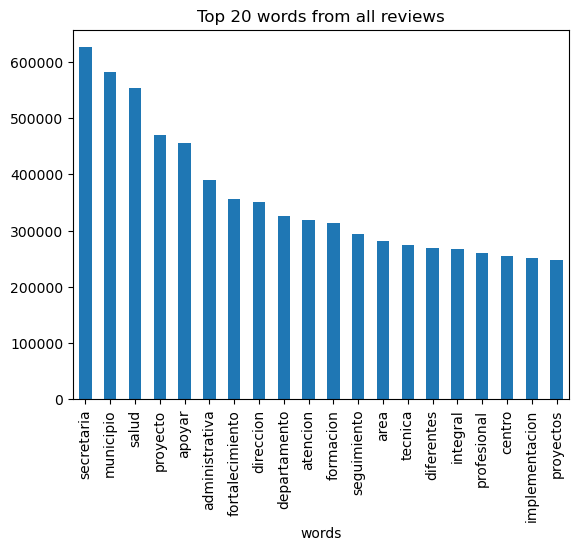

In [14]:
for word, freq in common_words:
    print(word, freq)
    
df_top_words = pd.DataFrame(common_words, columns=["words", "count"])
df_top_words.groupby("words").sum()["count"].sort_values(ascending=False).plot(
    kind="bar", title="Top 20 words from all reviews"
)
plt.show()

In [15]:
df.columns

Index(['nombre_entidad', 'nit_entidad', 'departamento', 'ciudad',
       'localizacion', 'orden', 'sector', 'rama', 'entidad_centralizada',
       'proceso_de_compra', 'id_contrato', 'referencia_del_contrato',
       'estado_contrato', 'codigo_de_categoria_principal',
       'descripcion_del_proceso', 'tipo_de_contrato',
       'modalidad_de_contratacion', 'justificacion_modalidad_de_contratacion',
       'fecha_de_firma', 'fecha_de_inicio_del_contrato',
       'fecha_de_fin_del_contrato', 'fecha_de_inicio_de_ejecucion',
       'fecha_de_fin_de_ejecucion', 'condiciones_de_entrega',
       'tipodocproveedor', 'documento_proveedor', 'proveedor_adjudicado',
       'es_grupo', 'es_pyme', 'habilita_pago_adelantado', 'liquidacion',
       'obligacion_ambiental', 'obligaciones_postconsumo', 'reversion',
       'origen_de_los_recursos', 'destino_gasto', 'valor_del_contrato',
       'valor_de_pago_adelantado', 'valor_facturado',
       'valor_pendiente_de_pago', 'valor_pagado', 'valor_amortizad

In [16]:
df.head()

nombre_entidad  nit_entidad  \
0                 dane - direccion territorial norte    899999027   
2  sena regional antioquia grupo administrativo c...    899999034   
3                          alcaldia local de usaquen    899999061   
4                              departamento del meta   8920001488   
5                       municipio manta cundinamarca    800094711   

                 departamento         ciudad  \
0                   atlantico    no definido   
2                   antioquia         itagui   
3  distrito capital de bogota         bogota   
4                        meta  villavicencio   
5                cundinamarca          manta   

                         localizacion        orden                   sector  \
0  colombia;  atlantico ; no definido     nacional  informacion estadistica   
2      colombia;  antioquia ;  itagui     nacional                  trabajo   
3           colombia; bogota;  bogota  territorial         servicio publico   
4    colombia;  meta ;  villavicencio  territorial         servicio publico   
5    colombia;  cundinamarca ;  manta  territorial         servicio publico   

        rama entidad_centralizada proceso_de_compra  ...  \
0  ejecutivo      descentralizada  co1.bdos.6741237  ...   
2  ejecutivo      descentralizada  co1.bdos.1099719  ...   
3  ejecutivo      descentralizada  co1.bdos.4578022  ...   
4  ejecutivo      descentralizada  co1.bdos.3550103  ...   
5  ejecutivo      descentralizada  co1.bdos.7117742  ...   

  nombre_ordenador_de_pago tipo_de_documento_ordenador_de_pago  \
0              no definido                         no definido   
2              no definido                         no definido   
3              no definido                         no definido   
4              no definido                         no definido   
5              no definido                         no definido   

  numero_de_documento_ordenador_de_pago duracion_en_dias  \
0                           no definido             82.0   
2                           no definido              NaN   
3                           no definido            180.0   
4                           no definido             30.0   
5                           no definido             24.0   

                     objeto_del_contrato_sin_numeros  \
0  ce__dra_bdc_th_tu prestacion de servicios de a...   
2  prestacion de los servicios personales de cara...   
3  prestar servicios profesionales para realizar ...   
4  fortalecer el departamento administrativo de p...   
5  prestacion de servicios de apoyo a la gestion ...   

                          objeto_del_contrato_tokens  \
0  [ce__dra_bdc_th_tu, prestacion, de, servicios,...   
2  [prestacion, de, los, servicios, personales, d...   
3  [prestar, servicios, profesionales, para, real...   
4  [fortalecer, el, departamento, administrativo,...   
5  [prestacion, de, servicios, de, apoyo, a, la, ...   

                          objeto_del_contrato_limpio  \
0  [ce__dra_bdc_th_tu, levantamiento, informacion...   
2  [personales, caracter, temporal, interprete, l...   
3  [acompanamiento, articulacion, seguimiento, di...   
4  [fortalecer, departamento, administrativo, pla...   
5  [ade, lantar, acciones, relacionadas, vigilanc...   

                 descripcion_del_proceso_sin_numeros  \
0  ce__dra_bdc_th_tu prestacion de servicios de a...   
2  prestacion de los servicios personales de cara...   
3  prestar servicios profesionales para realizar ...   
4  fortalecer el departamento administrativo de p...   
5  prestacion de servicios de apoyo a la gestion ...   

                      descripcion_del_proceso_tokens  \
0  [ce__dra_bdc_th_tu, prestacion, de, servicios,...   
2  [prestacion, de, los, servicios, personales, d...   
3  [prestar, servicios, profesionales, para, real...   
4  [fortalecer, el, departamento, administrativo,...   
5  [prestacion, de, servicios, de, apoyo, a, la, ...   

                      descripcion_del_proceso_limpio  


In [17]:
df = df[['nombre_entidad', 'nit_entidad', 'departamento', 'ciudad', 
           'objeto_del_contrato', 'objeto_del_contrato_limpio', 'localizacion', 
           'orden', 'sector', 'rama', 'entidad_centralizada', 'duracion_del_contrato', 
           'duracion_en_dias', 'proceso_de_compra', 'id_contrato', 
           'referencia_del_contrato', 'estado_contrato', 'codigo_de_categoria_principal', 
           'descripcion_del_proceso', 'descripcion_del_proceso_limpio', 'tipo_de_contrato', 
           'modalidad_de_contratacion', 'justificacion_modalidad_de_contratacion', 
           'fecha_de_firma', 'fecha_de_inicio_del_contrato', 'fecha_de_fin_del_contrato', 
           'fecha_de_inicio_de_ejecucion', 'fecha_de_fin_de_ejecucion', 'condiciones_de_entrega', 
           'tipodocproveedor', 'documento_proveedor', 'proveedor_adjudicado', 'es_grupo', 
           'es_pyme', 'liquidacion', 'obligacion_ambiental', 'obligaciones_postconsumo', 
           'origen_de_los_recursos', 'destino_gasto', 'valor_del_contrato', 
           'valor_de_pago_adelantado', 'valor_facturado', 'valor_pendiente_de_pago', 
           'valor_pagado', 'valor_amortizado', 'valor_pendiente_de_amortizacion', 
           'valor_pendiente_de_ejecucion', 'saldo_cdp', 'saldo_vigencia', 'espostconflicto', 
           'dias_adicionados', 'urlproceso', 'nombre_representante_legal', 
           'nacionalidad_representante_legal', 'tipo_de_identificacion_representante_legal', 
           'identificacion_representante_legal', 'genero_representante_legal', 
           'presupuesto_general_de_la_nacion___pgn', 'sistema_general_de_participaciones', 
           'sistema_general_de_regalias', 
           'recursos_propios_alcaldias,_gobernaciones_y_resguardos_indigenas', 
           'recursos_de_credito', 'recursos_propios', 'ultima_actualizacion', 
           'codigo_proveedor', 'codigo_entidad', 'fecha_inicio_liquidacion', 
           'fecha_fin_liquidacion', 'nombre_del_banco', 'tipo_de_cuenta', 
           'el_contrato_puede_ser_prorrogado', 'fecha_de_notificacion_de_prorrogacion', 
           'nombre_ordenador_del_gasto', 'nombre_supervisor']]


In [18]:
df.to_csv(r"D:\tesis_u_sabana\data\secop_2_contratos_1_clean.csv", sep="~", index=False)

In [19]:
df.head(10)

nombre_entidad  nit_entidad  \
0                  dane - direccion territorial norte    899999027   
2   sena regional antioquia grupo administrativo c...    899999034   
3                           alcaldia local de usaquen    899999061   
4                               departamento del meta   8920001488   
5                        municipio manta cundinamarca    800094711   
6   empresa de servicios publicos de acueducto; al...    901142488   
7                      alcaldia municipal de girardot    890680378   
8                                                 unp    900475780   
9   sena regional norte de santander grupo de apoy...    899999034   
10                              dane centro occidente    899999027   

                  departamento         ciudad  \
0                    atlantico    no definido   
2                    antioquia         itagui   
3   distrito capital de bogota         bogota   
4                         meta  villavicencio   
5                 cundinamarca          manta   
6                    santander         suaita   
7                 cundinamarca       girardot   
8   distrito capital de bogota         bogota   
9           norte de santander         cucuta   
10                      caldas      manizales   

                                  objeto_del_contrato  \
0   ce_2024_dra_bdc_th_tu prestacion de servicios ...   
2   prestacion de los servicios personales de cara...   
3   prestar servicios profesionales para realizar ...   
4   fortalecer el departamento administrativo de p...   
5   prestacion de servicios de apoyo a la gestion ...   
6   prestacion de servicios de apoyo a la gestion ...   
7   contratar la prestacion de servicios profesion...   
8   prestar los servicios de apoyo a la gestion en...   
9   54_9119_473 prestar servicios personales de ca...   
10  vigencia futura mercado_geih_u_th_tu_ot presta...   

                           objeto_del_contrato_limpio  \
0   [ce__dra_bdc_th_tu, levantamiento, informacion...   
2   [personales, caracter, temporal, interprete, l...   
3   [acompanamiento, articulacion, seguimiento, di...   
4   [fortalecer, departamento, administrativo, pla...   
5   [ade, lantar, acciones, relacionadas, vigilanc...   
6   [empresa, publicos, realizacion, tratamiento, ...   
7   [contratar, acompanamiento, seguimiento, difer...   
8   [misionales, desarrolla, subdireccion, evaluac...   
9   [__, personales, caracter, temporal, planear, ...   
10  [vigencia, futura, mercado_geih_u_th_tu_ot, se...   

                               localizacion        orden  \
0        colombia;  atlantico ; no definido     nacional   
2            colombia;  antioquia ;  itagui     nacional   
3                 colombia; bogota;  bogota  territorial   
4          colombia;  meta ;  villavicencio  territorial   
5          colombia;  cundinamarca ;  manta  territorial   
6            colombia;  santander ;  suaita  territorial   
7          colombia; cundinamarca; girardot  territorial   
8                 colombia; bogota;  bogota     nacional   
9   colombia;  norte de santander ;  cucuta     nacional   
10              colombia; caldas; manizales     nacional   

                     sector                  rama  ... codigo_proveedor  \
0   informacion estadistica             ejecutivo  ...        727141632   
2                   trabajo             ejecutivo  ...        708123252   
3          servicio publico             ejecutivo  ...        712427863   
4          servicio publico             ejecutivo  ...        716433206   
5          servicio publico             ejecutivo  ...        729397109   
6     no aplicano pertenece  corporacion autonoma  ...        720343201   
7          servicio publico             ejecutivo  ...        715368742   
8                   defensa             ejecutivo  ...        712471390   
9        educacion nacional             ejecutivo  ...        708587761   
10         servicio publico             ejecutivo  ...       